> ## Update
> - 添加了利用临床数据，使用生存分析的方法根据 p 值选出最优的聚合簇数量
> - 将 clinical 数据中 OS.time 的NaN值替换为 last_contact_days_to 值
> - 绘制 p_value - k 图



## 1. 数据预处理

### 1.1 数据加载

In [ ]:
import pandas as pd
import numpy as np

# 选取 gene_expression, DNA methylation(450k), miRNA expression 数据
gene_expression_raw_data = pd.read_csv('data/gene_expression/batch_effects_normalized_mRNA_data', sep='\t', index_col=0, nrows=2000)
dna_methylation_450k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_450k', sep='\t', index_col=0, nrows=3000)
miRNA_expression_raw_data = pd.read_csv('data/miRNA_expression/batch_effects_normalized_miRNA_data', sep='\t', index_col=0, nrows=1000)


In [22]:
# 选取 clinical 数据
clinical_raw_data = pd.read_csv('data/clinical/phenotype_curated_clinical_data', sep='\t', index_col=0)

In [23]:
# 打印原始数据形状
gene_expression_raw_data.shape, dna_methylation_450k_raw_data.shape, miRNA_expression_raw_data.shape, clinical_raw_data.shape

((2000, 11069), (3000, 9664), (743, 10824), (12591, 33))

### 1.2 样本匹配

In [24]:
# 获取每个数据集的列名（样本 ID）
gene_expression_samples = set(gene_expression_raw_data.columns)
dna_methylation_samples = set(dna_methylation_450k_raw_data.columns)
miRNA_expression_samples = set(miRNA_expression_raw_data.columns)

clinical_samples = set(clinical_raw_data.index)

# 找到所有数据集中共有的样本 ID
common_samples = gene_expression_samples & dna_methylation_samples & miRNA_expression_samples & clinical_samples

common_samples = list(common_samples)

# 使用共有的样本 ID 来过滤每个数据集
gene_expression_data = gene_expression_raw_data[common_samples]
dna_methylation_data = dna_methylation_450k_raw_data[common_samples]
miRNA_expression_data = miRNA_expression_raw_data[common_samples]

clinical_data = clinical_raw_data.loc[common_samples]


In [25]:
# 查看过滤后的数据集形状
gene_expression_data.shape, dna_methylation_data.shape, miRNA_expression_data.shape, clinical_data.shape

((2000, 8920), (3000, 8920), (743, 8920), (8920, 33))

### 1.3 数据清洗

In [26]:
# 定义清理函数
def clean_data(data):
    data = data.dropna(axis=1, thresh=0.7*data.shape[0])
    data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
    data = data.fillna(0)
    return data

# 清理每种数据
gene_expression_data = clean_data(gene_expression_data)
dna_methylation_data = clean_data(dna_methylation_data)
miRNA_expression_data = clean_data(miRNA_expression_data)

In [27]:
# 将 clinical 数据中 OS.time 的NaN值替换为 last_contact_days_to 值
clinical_data['OS.time'] = clinical_data['OS.time'].fillna(clinical_data['last_contact_days_to'])
clinical_data['OS.time'].fillna(clinical_data['OS.time'].mean(), inplace=True)

In [28]:
# 检查是否包含NaN值
print("Gene Expression Data contains NaN:", gene_expression_data.isnull().values.any())
print("DNA Methylation 450K Data contains NaN:", dna_methylation_data.isnull().values.any())
print("miRNA Expression Data contains NaN:", miRNA_expression_data.isnull().values.any())

# 检查clinical的Os.time, vital_status是否包含NaN值
print("Clinical Data contains NaN in OS.time:", clinical_data['OS.time'].isnull().values.any())

Gene Expression Data contains NaN: False
DNA Methylation 450K Data contains NaN: False
miRNA Expression Data contains NaN: False
Clinical Data contains NaN in OS.time: False


### 1.4 数据标准化

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

gene_expression_data = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                           index=gene_expression_data.index, columns=gene_expression_data.columns)
dna_methylation_data = pd.DataFrame(scaler.fit_transform(dna_methylation_data), 
                                       index=dna_methylation_data.index, columns=dna_methylation_data.columns)
miRNA_expression_data = pd.DataFrame(scaler.fit_transform(miRNA_expression_data), 
                                              index=miRNA_expression_data.index, columns=miRNA_expression_data.columns)


## 2. 数据整合


### 2.1 数据降维（使用 PCA）

In [30]:
from sklearn.decomposition import PCA

# 转置方便后续操作
gene_expression_data = gene_expression_data.T
dna_methylation_data = dna_methylation_data.T
miRNA_expression_data = miRNA_expression_data.T

# 使用 PCA 降维数据集到 
gene_pca = PCA(n_components=1000)
dna_pca = PCA(n_components=1000)
miRNA_pca = PCA(n_components=200)
gene_expression_pca = gene_pca.fit_transform(gene_expression_data)
dna_methylation_pca = dna_pca.fit_transform(dna_methylation_data)
miRNA_expression_pca = miRNA_pca.fit_transform(miRNA_expression_data)

### 2.1 数据降维 (使用自编码器)

In [31]:
# 查看PCA降维后的数据集形状
gene_expression_pca.shape, dna_methylation_pca.shape, miRNA_expression_pca.shape

((8920, 1000), (8920, 1000), (8920, 200))

In [32]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def prepare_data(data, test_size=0.2, random_state=None):
    # 将 DataFrame 转换为 NumPy 数组并指定数据类型为 float32
    data_np = data.astype(np.float32)
    
    # 划分训练集和测试集
    train_data, test_data = train_test_split(data_np, test_size=test_size, random_state=random_state)
    
    # 将 NumPy 数组转换为 PyTorch 张量
    train_tensor = torch.tensor(train_data)
    test_tensor = torch.tensor(test_data)
    
    # 将张量移动到 GPU 上
    train_tensor = train_tensor.to(device)
    test_tensor = test_tensor.to(device)
    
    return data_np, train_tensor, test_tensor

# 使用函数
gene_expression_data, train_gene_expression, test_gene_expression = prepare_data(gene_expression_pca)
dna_methylation_data, train_dna_methylation, test_dna_methylation = prepare_data(dna_methylation_pca)
miRNA_expression_data, train_miRNA_expression, test_miRNA_expression = prepare_data(miRNA_expression_pca)


In [33]:
import torch

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()

        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train(self, x_train, x_test, epochs=50, batch_size=256):
        """
        Train the autoencoder and return the encoder and decoder models.

        Parameters:
        - x_train: Training data
        - x_test: Testing data
        - epochs: Number of training epochs
        - batch_size: Batch size

        Returns:
        - encoder: Encoder model
        - decoder: Decoder model
        """
        # Convert data to tensors
        x_train = x_train.clone().detach().to(dtype=torch.float32)
        x_test = x_test.clone().detach().to(dtype=torch.float32)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)

        # Initialize a list to store loss values
        loss_values = []

        # Train the autoencoder
        for epoch in range(epochs):
            # Shuffle the training data
            indices = torch.randperm(x_train.size(0))
            x_train = x_train[indices]

            # Mini-batch training
            for i in range(0, x_train.size(0), batch_size):
                inputs = x_train[i:i+batch_size]

                # Forward pass
                outputs = self(inputs)
                loss = criterion(outputs, inputs)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Append loss value
            loss_values.append(loss.item())

            # Print loss or other information
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

        # Plotting the loss values
        plt.figure(figsize=(10, 6))
        plt.plot(loss_values, label='Training Loss')
        plt.title('Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_loss.png')  # Save the plot as a .png file
        plt.show()  # Optionally display the plot

        # Return encoder and decoder models
        return self.encoder, self.decoder

    def encode_data(self, encoder, data):
        """
        Use the encoder to perform dimensionality reduction on the data.

        Parameters:
        - encoder: Encoder model
        - data: Data to be reduced

        Returns:
        - encoded_data: Reduced data
        """
        encoded_data = encoder(torch.tensor(data, dtype=torch.float32))
        return encoded_data.detach().numpy()

Epoch 1/100, Loss: 0.02188573032617569
Epoch 2/100, Loss: 0.019642895087599754
Epoch 3/100, Loss: 0.015140852890908718
Epoch 4/100, Loss: 0.017288899049162865
Epoch 5/100, Loss: 0.014096250757575035
Epoch 6/100, Loss: 0.015268005430698395
Epoch 7/100, Loss: 0.015514138154685497
Epoch 8/100, Loss: 0.014269943349063396
Epoch 9/100, Loss: 0.01467218715697527
Epoch 10/100, Loss: 0.015627680346369743
Epoch 11/100, Loss: 0.01502923108637333
Epoch 12/100, Loss: 0.014808550477027893
Epoch 13/100, Loss: 0.01458362303674221
Epoch 14/100, Loss: 0.01335723977535963
Epoch 15/100, Loss: 0.01368467416614294
Epoch 16/100, Loss: 0.0142268231138587
Epoch 17/100, Loss: 0.015268596820533276
Epoch 18/100, Loss: 0.01408905815333128
Epoch 19/100, Loss: 0.013690149411559105
Epoch 20/100, Loss: 0.012467827647924423
Epoch 21/100, Loss: 0.012889125384390354
Epoch 22/100, Loss: 0.015593876130878925
Epoch 23/100, Loss: 0.014162558130919933
Epoch 24/100, Loss: 0.013626886531710625
Epoch 25/100, Loss: 0.012092560529

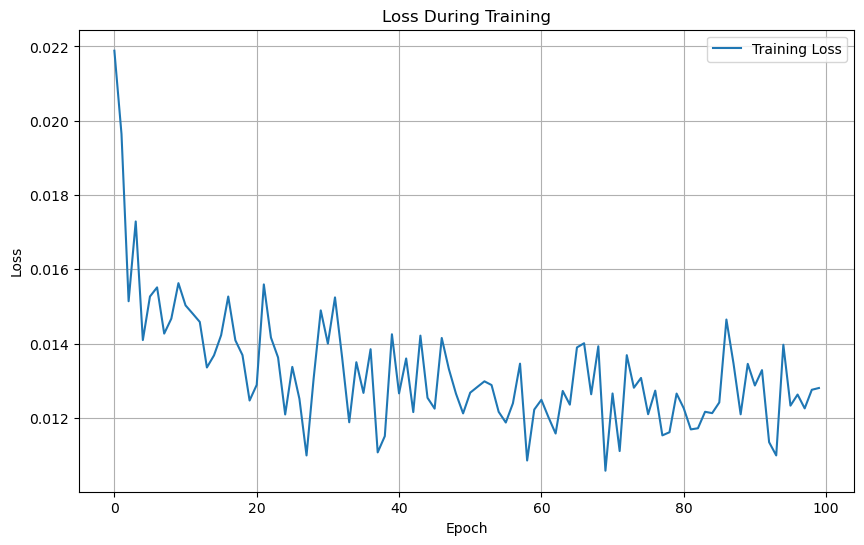

Epoch 1/100, Loss: 0.06771281361579895
Epoch 2/100, Loss: 0.06190476939082146
Epoch 3/100, Loss: 0.044916167855262756
Epoch 4/100, Loss: 0.05365078151226044
Epoch 5/100, Loss: 0.05445670336484909
Epoch 6/100, Loss: 0.05755288526415825
Epoch 7/100, Loss: 0.06099242717027664
Epoch 8/100, Loss: 0.054432373493909836
Epoch 9/100, Loss: 0.052928294986486435
Epoch 10/100, Loss: 0.05085720121860504
Epoch 11/100, Loss: 0.05806107819080353
Epoch 12/100, Loss: 0.04156484082341194
Epoch 13/100, Loss: 0.05238008871674538
Epoch 14/100, Loss: 0.04912067577242851
Epoch 15/100, Loss: 0.05533863976597786
Epoch 16/100, Loss: 0.06943728774785995
Epoch 17/100, Loss: 0.05550013855099678
Epoch 18/100, Loss: 0.046388283371925354
Epoch 19/100, Loss: 0.03972741961479187
Epoch 20/100, Loss: 0.04094988852739334
Epoch 21/100, Loss: 0.05116574093699455
Epoch 22/100, Loss: 0.05350686237215996
Epoch 23/100, Loss: 0.04885770380496979
Epoch 24/100, Loss: 0.045943133533000946
Epoch 25/100, Loss: 0.056774526834487915
Epo

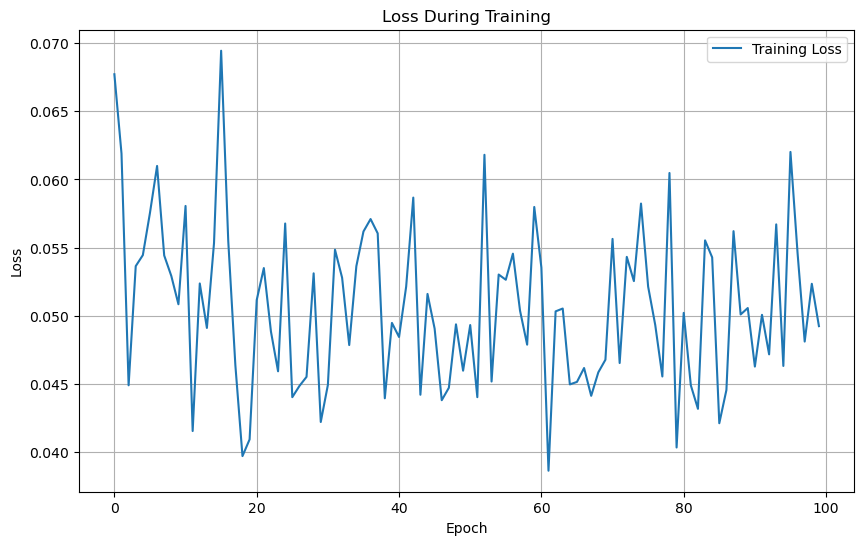

Epoch 1/100, Loss: 0.026728563010692596
Epoch 2/100, Loss: 0.020407292991876602
Epoch 3/100, Loss: 0.01622338406741619
Epoch 4/100, Loss: 0.01563190296292305
Epoch 5/100, Loss: 0.015633318573236465
Epoch 6/100, Loss: 0.013922895304858685
Epoch 7/100, Loss: 0.015688635408878326
Epoch 8/100, Loss: 0.016710232943296432
Epoch 9/100, Loss: 0.013975518755614758
Epoch 10/100, Loss: 0.01577981747686863
Epoch 11/100, Loss: 0.014008965343236923
Epoch 12/100, Loss: 0.012532154098153114
Epoch 13/100, Loss: 0.013865327462553978
Epoch 14/100, Loss: 0.015170463360846043
Epoch 15/100, Loss: 0.013243409804999828
Epoch 16/100, Loss: 0.013069272972643375
Epoch 17/100, Loss: 0.014923215843737125
Epoch 18/100, Loss: 0.013972342945635319
Epoch 19/100, Loss: 0.01274746935814619
Epoch 20/100, Loss: 0.014626319520175457
Epoch 21/100, Loss: 0.013125593774020672
Epoch 22/100, Loss: 0.012313712388277054
Epoch 23/100, Loss: 0.014035552740097046
Epoch 24/100, Loss: 0.013713156804442406
Epoch 25/100, Loss: 0.0138255

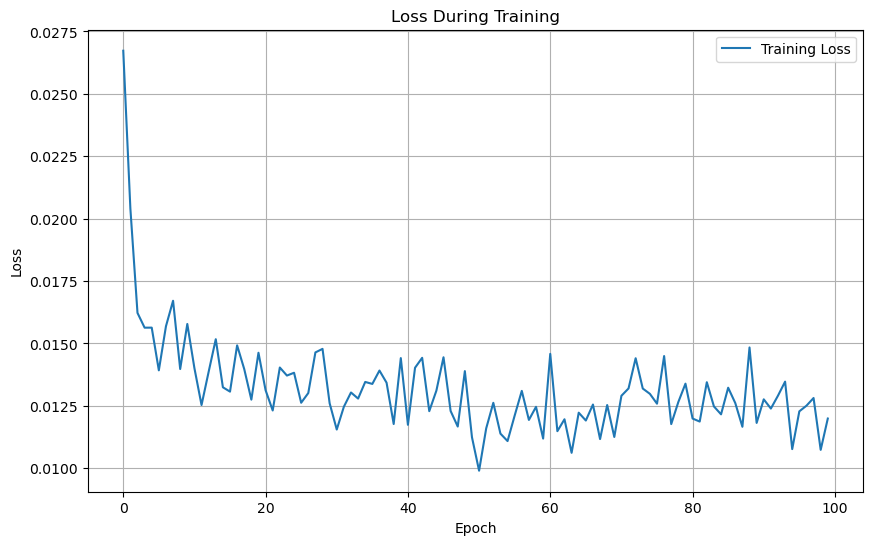

((8920, 50), (8920, 50), (8920, 50))

In [34]:
# from auto_encoder import AutoEncoder

# 创建自编码器实例
encoding_dim = 50 # 输出维度为 50
gene_autoencoder = AutoEncoder(input_dim=train_gene_expression.shape[1], encoding_dim=encoding_dim).to(device)
dna_autoencoder = AutoEncoder(input_dim=train_dna_methylation.shape[1], encoding_dim=encoding_dim).to(device)
miRNA_autoencoder = AutoEncoder(input_dim=train_miRNA_expression.shape[1], encoding_dim=encoding_dim).to(device)

# 训练自编码器并获取编码器
gene_encoder, _ = gene_autoencoder.train(x_train=train_gene_expression, x_test=test_gene_expression, epochs=100, batch_size=32)
dna_encoder, _ = dna_autoencoder.train(x_train=train_dna_methylation, x_test=test_dna_methylation, epochs=100, batch_size=32)
miRNA_encoder, _ = miRNA_autoencoder.train(x_train=train_miRNA_expression, x_test=test_miRNA_expression, epochs=100, batch_size=32)

# 使用编码器对数据进行降维
gene_encoded_data = gene_autoencoder.encode_data(gene_encoder, gene_expression_data)
dna_encoder_data = dna_autoencoder.encode_data(dna_encoder, dna_methylation_data)
miRNA_encoded_data = miRNA_autoencoder.encode_data(miRNA_encoder, miRNA_expression_data)

gene_encoded_data.shape, dna_encoder_data.shape, miRNA_encoded_data.shape

In [35]:
import numpy as np

# 拼接特征
combined_data = np.concatenate((gene_encoded_data, dna_encoder_data, miRNA_encoded_data), axis=1)

In [36]:
# 查看拼接后的数据集维度, 检查是否包含NaN值
combined_data.shape

(8920, 150)

In [42]:
combined_data

array([[1.4486085 , 0.09171691, 0.        , ..., 1.4638398 , 0.6353187 ,
        0.16081637],
       [1.4814649 , 1.0218134 , 1.5990273 , ..., 1.5766139 , 1.3071183 ,
        0.68706024],
       [0.75336486, 1.6455816 , 1.1998931 , ..., 1.2235577 , 0.6565689 ,
        1.4807255 ],
       ...,
       [0.5733013 , 0.7202835 , 0.85710144, ..., 1.2175971 , 0.9907243 ,
        0.8789274 ],
       [1.5232527 , 1.3034416 , 0.        , ..., 0.37331456, 0.5178    ,
        0.43616486],
       [0.03777095, 0.9474224 , 2.1085265 , ..., 0.57474554, 0.9676277 ,
        0.6167077 ]], dtype=float32)

## 3. 聚类分析


### 3.1 评估 (使用轮廓系数)

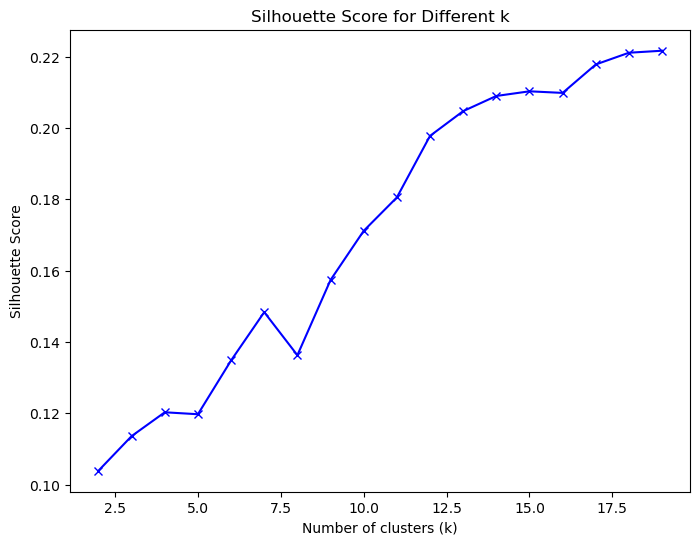

In [37]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 寻找最优的簇数量
silhouette_scores = []
K = range(2, 20)  # 我们尝试从2到20个簇
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(combined_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(combined_data, labels)
    silhouette_scores.append(silhouette_avg)

# 可视化不同簇数量下的轮廓系数
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()


Best number of clusters: 19


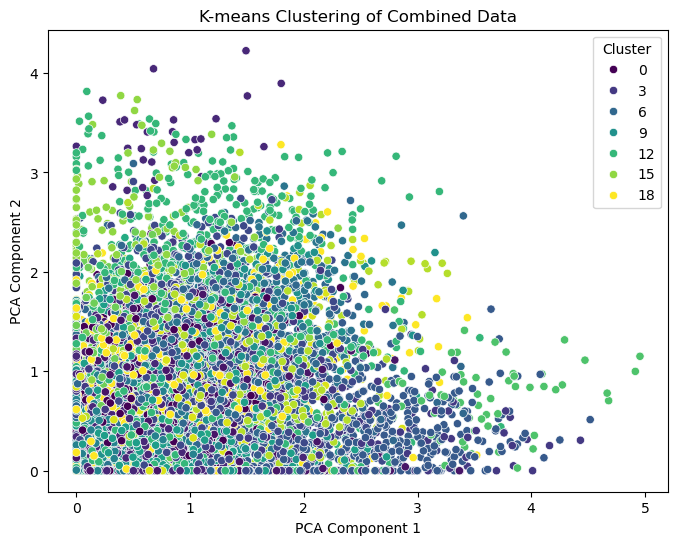

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选择最优簇数量并进行最终聚类
best_k = K[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

kmeans = KMeans(n_clusters=best_k)
kmeans.fit(combined_data)
labels = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(8, 6))
sns.scatterplot(x=combined_data[:, 0], y=combined_data[:, 1], hue=labels, palette='viridis')
plt.title('K-means Clustering of Combined Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

### 3.2 评估 (使用生存分析)

### 4.2 生存分析

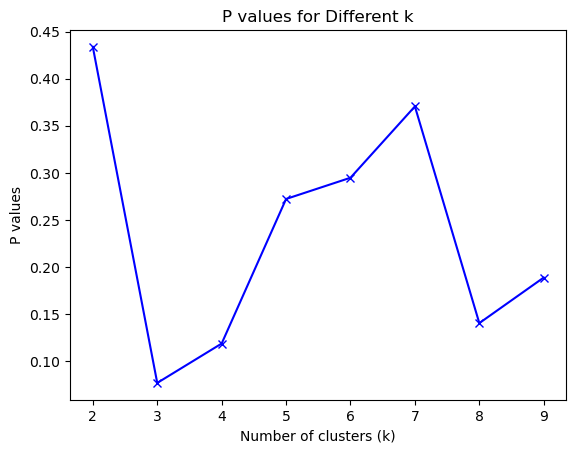

Optimal k: 3 with p-value: 0.07662982390493307


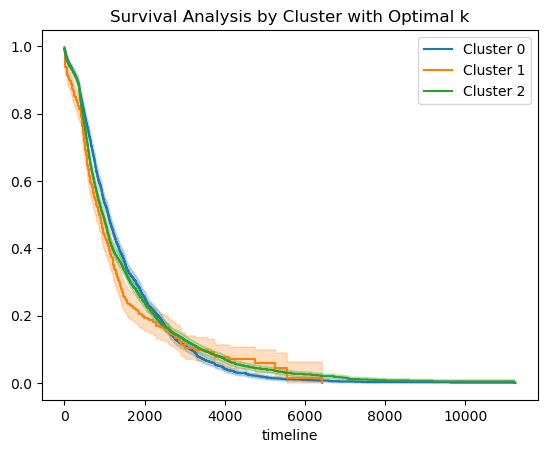

In [39]:
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k_and_plot(survival_data, combined_data, k_range):
    optimal_k = None
    best_p_value = 1  # 初始化为最大的p值
    best_labels = None
    total_p_values = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(combined_data)
        
        survival_data['Cluster'] = labels
        kmf = KaplanMeierFitter()
        survival_curves = []

        for cluster in np.unique(labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E)
            survival_curves.append((T, E))
        
        # 计算不同聚类之间的生存曲线差异
        p_values = []
        for i in range(len(survival_curves) - 1):
            for j in range(i + 1, len(survival_curves)):
                result = logrank_test(survival_curves[i][0], survival_curves[j][0], event_observed_A=survival_curves[i][1], event_observed_B=survival_curves[j][1])
                p_values.append(result.p_value)
            
                
        # 选择差异最大（p值最小）的聚类结果
        min_p_value = np.mean(p_values) if p_values else 1
        total_p_values.append(min_p_value)
        if min_p_value < best_p_value:
            best_p_value = min_p_value
            optimal_k = k
            best_labels = labels
            
    # 可视化不同簇数量下的轮廓系数
    plt.plot(k_range, total_p_values, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('P values')
    plt.title('P values for Different k')
    plt.show()

    # 使用最优的k值进行聚类，并画出生存曲线图
    if optimal_k:
        print(f"Optimal k: {optimal_k} with p-value: {best_p_value}")
        survival_data['Cluster'] = best_labels
        kmf = KaplanMeierFitter()

        for cluster in np.unique(best_labels):
            cluster_data = survival_data[survival_data['Cluster'] == cluster]
            T = cluster_data['OS.time']
            E = np.where(cluster_data['vital_status'] == 'Alive', 1, 0)
            kmf.fit(T, event_observed=E, label=f'Cluster {cluster}')
            kmf.plot_survival_function()

        plt.title('Survival Analysis by Cluster with Optimal k')
        plt.show()
    else:
        print("No optimal k found.")


find_optimal_k_and_plot(clinical_data, combined_data, range(2, 10))